In [219]:
import os
from pprint import *
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil import parser
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tqdm import *
from pathlib import Path

In [220]:
channels = pd.read_csv('../csv/channels.csv', index_col=0)
videos = pd.read_csv('../csv/videos2.csv', index_col = 0, sep =';')
colors = pd.read_csv('../csv/videos_colors.csv', index_col = 0, sep =';')
videos = pd.merge(videos, colors, left_on="videoId", right_on="videoId", how="left")

In [221]:
videos = videos.loc[videos.duration < 5000]
videos = videos.drop(columns = ['nb_diff_words_title','nb_sent_title','nb_hashtags_title',
                                'hashtags_prop_title','sent_prop_title','diff_words_prop_title',
                               'nb_words_title', 'emojis_prop_title','punct_prop_title'])

<AxesSubplot:xlabel='duration', ylabel='Count'>

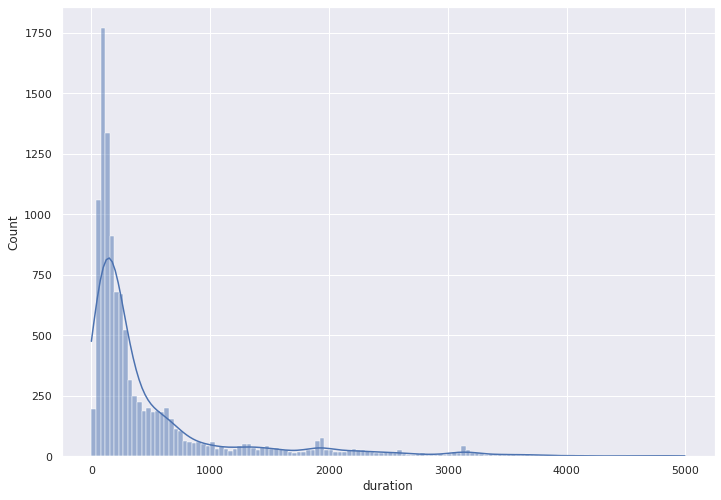

In [222]:
sns.histplot(x=videos.duration, kde = True)

<AxesSubplot:xlabel='duration', ylabel='engagement'>

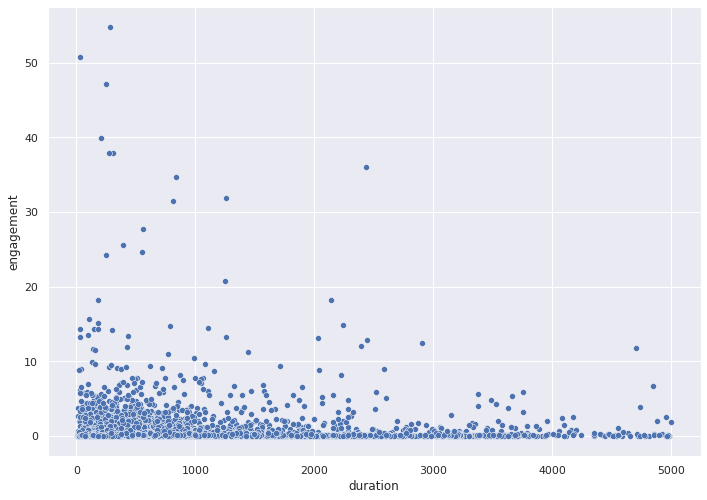

In [223]:
sns.scatterplot(
    x = 'duration',
    y = 'engagement',
    data = videos,
)

<AxesSubplot:>

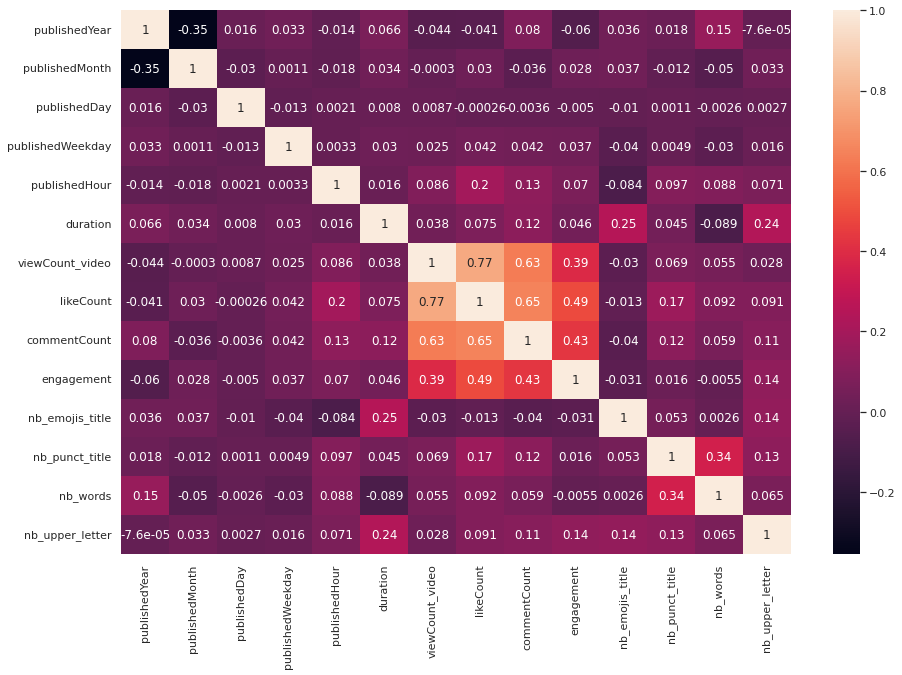

In [224]:
plt.figure(figsize=(15,10))
sns.heatmap(videos.corr(), annot = True)

Index(['publishedWeekday', 'publishedHour', 'duration', 'nb_emojis_title',
       'nb_punct_title', 'nb_words', 'nb_upper_letter'],
      dtype='object')


<AxesSubplot:xlabel='axis1', ylabel='axis2'>

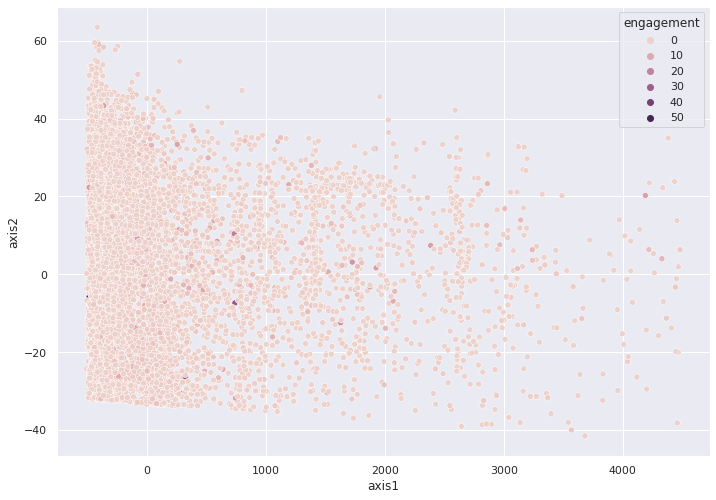

In [226]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = videos.drop(columns=['channelId','videoId','tn_url','publishedAt_video','publishedYear','publishedMonth',
                          'publishedDay', 'title_video','viewCount_video','likeCount','commentCount','title_channel',
                         'engagement', 'color_1_name','color_2_name','color_3_name'])

print(df.columns)
cls = PCA(n_components=5)
pcs = cls.fit_transform(df)

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
X['engagement'] = videos.engagement

sns.scatterplot(x = "axis1", y = "axis2", hue = "engagement", data = X)


## Etudes des vidéos à fort engagement

In [227]:
fam = videos.loc[videos.engagement > 1]

<AxesSubplot:xlabel='count', ylabel='title_channel'>

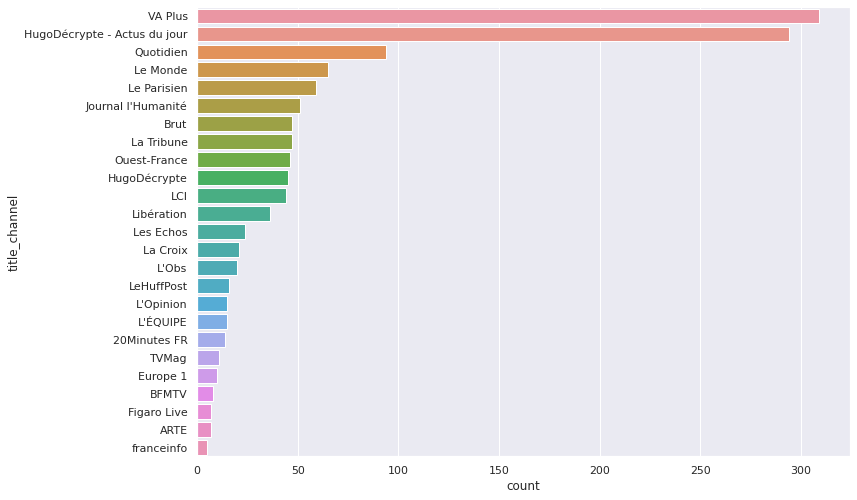

In [228]:
sns.countplot(
    y = "title_channel",
    data = fam,
    order = fam['title_channel'].value_counts().index
)

Index(['publishedWeekday', 'publishedHour', 'duration', 'nb_emojis_title',
       'nb_punct_title', 'nb_words', 'nb_upper_letter'],
      dtype='object')


<AxesSubplot:xlabel='axis1', ylabel='axis2'>

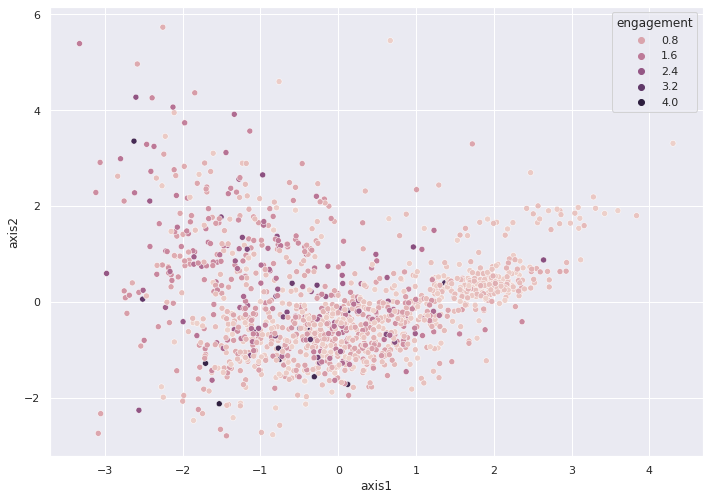

In [229]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = fam.drop(columns=['channelId','videoId','tn_url','publishedAt_video','publishedYear','publishedMonth',
                          'publishedDay', 'title_video','viewCount_video','likeCount','commentCount','title_channel',
                         'engagement', 'color_1_name','color_2_name','color_3_name'])

print(df.columns)
cls = PCA(n_components=5)
pcs = cls.fit_transform(StandardScaler().fit_transform(df))

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
X['engagement'] = np.log(fam.engagement)

sns.scatterplot(x = "axis1", y = "axis2", hue = "engagement", data = X)


In [230]:
channels_stats_fam = fam.groupby('title_channel').mean()
not_fam = videos.loc[videos.engagement <= 1]
channels_stats_not_fam = not_fam.groupby('title_channel').mean()

In [231]:
videos = videos.assign(
    fam = videos.engagement > 1
)

<AxesSubplot:xlabel='publishedHour', ylabel='count'>

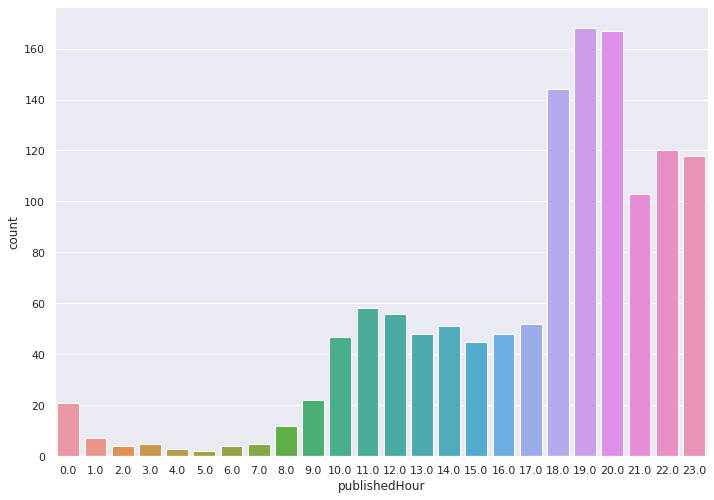

In [232]:
sns.countplot(x='publishedHour', data = fam)

<AxesSubplot:xlabel='publishedHour', ylabel='count'>

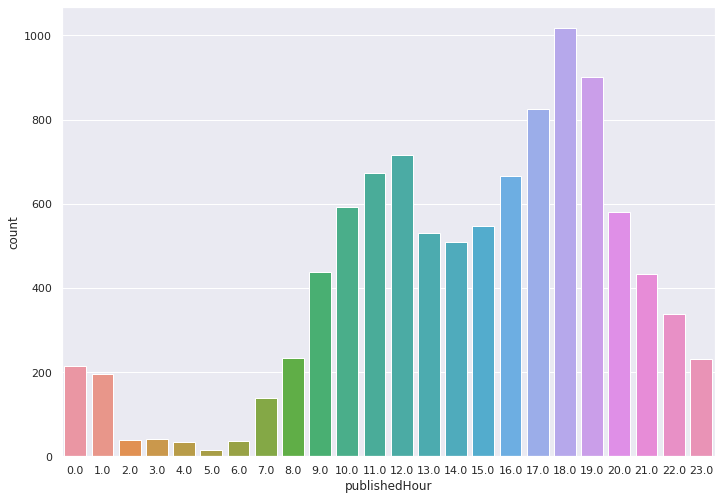

In [233]:
sns.countplot(x='publishedHour', data = not_fam)

<AxesSubplot:>

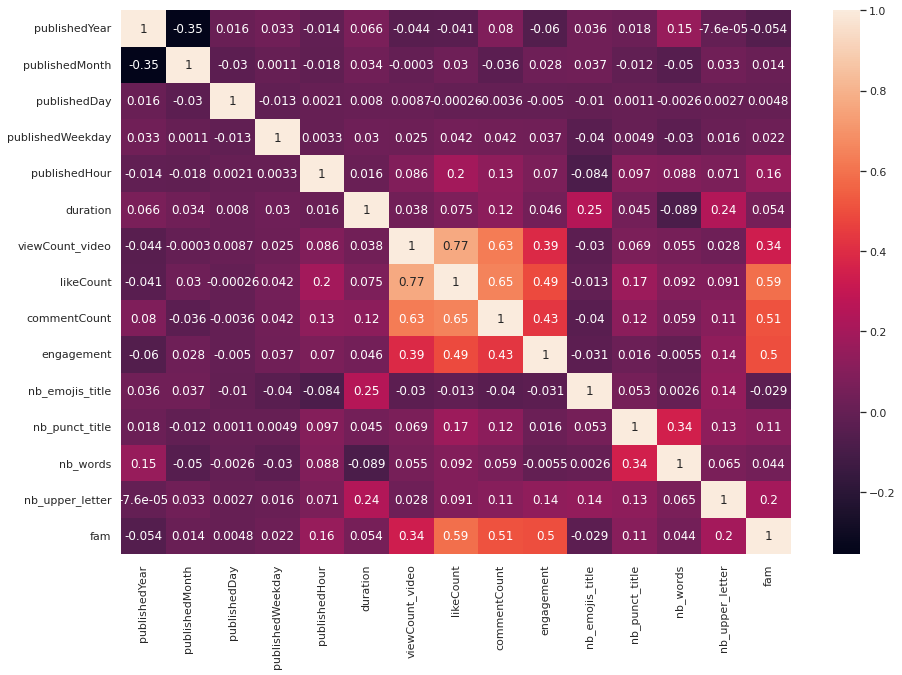

In [234]:
plt.figure(figsize=(15,10))
sns.heatmap(videos.corr(), annot = True)

## Features importance

In [255]:
df = videos.drop(columns=['channelId','videoId','tn_url', 'publishedAt_video', 'title_video', 'title_channel',
                         'engagement','likeCount','viewCount_video','commentCount','color_2_name','color_3_name'])
color_one_hot = pd.get_dummies(df.color_1_name, prefix='color')
df = df.join(color_one_hot)
df = df.drop(columns='color_1_name')
X = df.drop(columns=['fam'])
y = df['fam']

<AxesSubplot:>

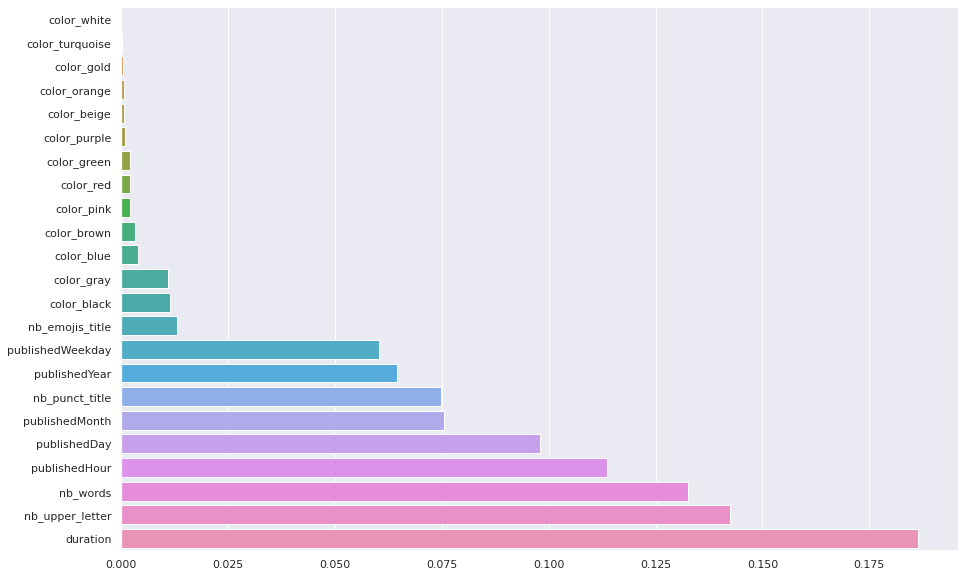

In [257]:
from sklearn.ensemble import RandomForestClassifier
cls = RandomForestClassifier(max_depth=100)
cls.fit(X, y)
importance = cls.feature_importances_
features = X.columns
df_importance = pd.DataFrame({'features':features,'importance':importance})
df_importance = df_importance.sort_values(by = ['importance'], ascending = False)
plt.figure(figsize=(15,10))
sns.barplot(x = importance, y = features, data = df_importance, order=df_importance.sort_values('importance').features)

In [276]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_predict

In [283]:
df = videos.drop(columns=['channelId','videoId','tn_url', 'publishedAt_video', 'title_video', 'title_channel'
                          ,'likeCount','viewCount_video','commentCount','color_2_name','color_3_name','fam'])
color_one_hot = pd.get_dummies(df.color_1_name, prefix='color')
df = df.join(color_one_hot)
df = df.drop(columns='color_1_name')
df = df.dropna()
X = df.drop(columns=['engagement'])
y = df['engagement']

In [289]:
fam = videos.loc[videos.fam == True]
unfam = videos.loc[videos.fam == False]

In [292]:
mean_fam = fam.groupby('title_channel').mean()
mean_unfam = unfam.groupby('title_channel').mean()

In [304]:
mean_fam - mean_unfam

,publishedYear,publishedMonth,publishedDay,publishedWeekday,publishedHour,duration,viewCount_video,likeCount,commentCount,engagement,nb_emojis_title,nb_punct_title,nb_words,nb_upper_letter,fam
title_channel,,,,,,,,,,,,,,,
20Minutes FR,0.000000,0.197581,-1.214574,0.526210,0.823445,-32.906106,5.234371e+04,384.824309,465.392641,1.526424,0.000000,-0.097062,12.741071,0.510369,1.0
ARTE,-1.261156,1.303085,1.799042,-0.727164,0.857742,505.797844,3.839110e+06,44010.654388,5596.936807,2.066983,-0.033543,-0.367475,-11.971548,-0.687631,1.0
BFMTV,-1.623560,1.060701,-2.590691,-0.466411,2.027351,-243.142274,1.783173e+06,16192.045341,4409.483801,1.624285,-0.005758,0.420585,10.354367,0.619722,1.0
Brut,-0.165267,0.104097,-0.477184,0.315789,0.464259,148.009005,9.382298e+05,31741.562337,1727.917653,2.391730,0.016891,-0.279255,-2.872480,-0.184071,1.0
Europe 1,-0.186135,0.378683,-2.518718,-0.500347,1.064818,415.752340,7.392620e+05,11989.182669,2267.347834,1.384129,0.000000,0.245061,2.081456,0.532929,1.0
Figaro Live,-0.143169,2.057080,-4.193387,0.295072,-1.758578,628.713350,5.398329e+05,6033.496718,1571.426065,1.747944,-0.014972,0.274797,-10.221460,-2.188397,1.0
HugoDécrypte,0.733333,-4.577778,-6.000000,0.888889,-0.066667,131.244444,5.179168e+05,26276.533333,2089.866667,4.474196,0.000000,-0.044444,9.444444,0.711111,1.0
HugoDécrypte - Actus du jour,-0.612179,-0.694466,0.154239,-0.072246,-0.621860,-30.792255,1.101056e+05,8475.300464,676.984465,0.579259,-0.049222,0.292452,-1.170330,0.188841,1.0
Journal l'Humanité,0.544330,-1.245701,-1.480727,0.450042,0.101121,-145.828309,4.658682e+04,1493.508864,441.876444,3.744868,-0.002278,-0.421457,-0.644379,0.703113,1.0


<AxesSubplot:xlabel='duration', ylabel='engagement'>

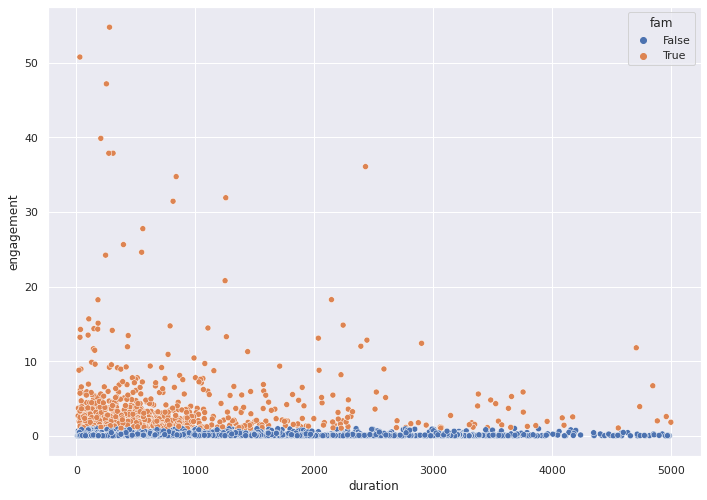

In [300]:
sns.scatterplot(
    x = 'duration',
    y = 'engagement',
    hue = "fam",
    data = videos,
)

<AxesSubplot:xlabel='count', ylabel='title_channel'>

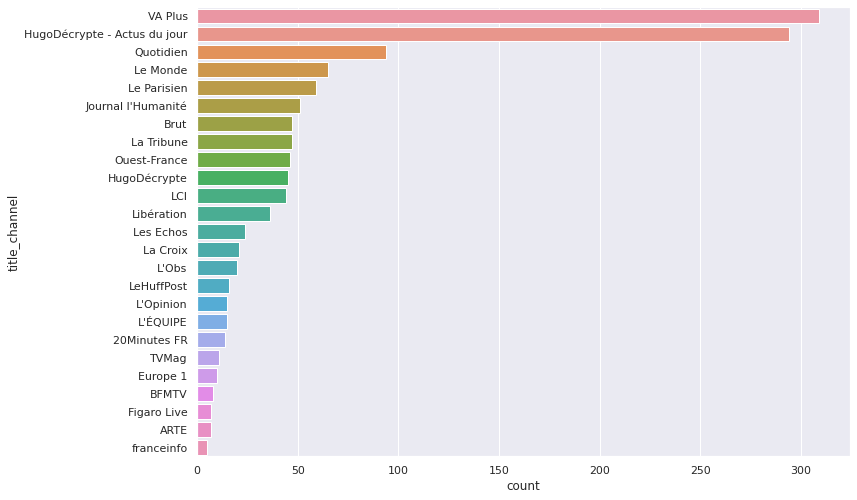

In [315]:
sns.countplot(
    y = "title_channel",
    data = fam,
    order = fam['title_channel'].value_counts().index
)

In [318]:
videos.title_channel.unique()

array(['Le Monde', 'franceinfo', 'LeHuffPost', 'Figaro Live',
       'Le Parisien', 'Les Echos', "L'ÉQUIPE", 'Libération', 'La Croix',
       "Journal l'Humanité", "L'Opinion", 'Brut', 'BFMTV', "L'Obs",
       'La Tribune', 'VA Plus', 'Ouest-France', '20Minutes FR',
       'HugoDécrypte', 'HugoDécrypte - Actus du jour', 'Europe 1',
       'Quotidien', 'ARTE', 'TVMag', 'LCI'], dtype=object)

/tmp/ipykernel_40548/465656455.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


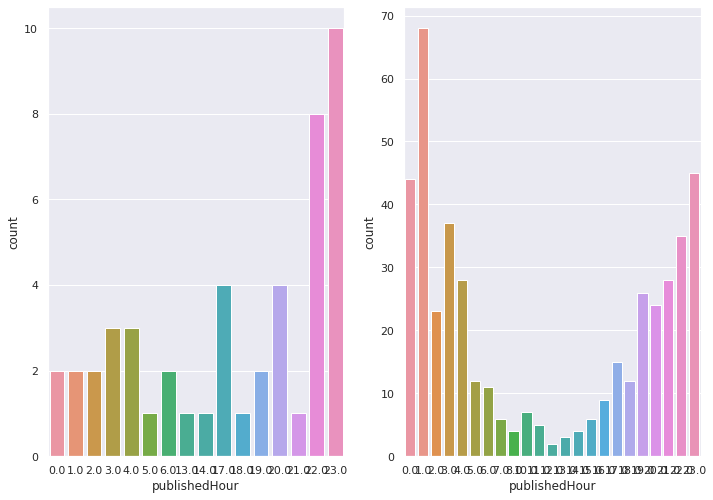

In [322]:
fig, ax =plt.subplots(1,2)
media = 'La Tribune'

sns.countplot(x='publishedHour', data = fam.loc[fam.title_channel == media],ax=ax[0])

sns.countplot(x='publishedHour', data = unfam.loc[unfam.title_channel == media], ax=ax[1])

fig.show()